In [166]:
# import itk
import sys
import SimpleITK as sitk
import os
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
import math

from scipy.interpolate import RegularGridInterpolator, interpn

from skimage import measure
from mayavi import mlab
# ipython --gui=qt/
# mlab.init_notebook()

import pylab as pl
import trimesh
# import open3d

# from flownet3d import train
# import tensorflow as tf


In [2]:
path = "/Users/janelameski/Desktop/jane/Thesis/"
path_to_normal_deformed = path + "normal_and_deformed/"
path_to_point_clouds = path + "point_clouds/"

In [3]:
import numpy as np
from matplotlib import cm

popi_body_label = 0
popi_air_label = 1
popi_lung_label = 2

def read_POPI_points(file_name):
    """
    Read the Point-validated Pixel-based Breathing Thorax Model (POPI) landmark points file.
    The file is an ASCII file with X Y Z coordinates in each line and the first line is a header.

    Args:
       file_name: full path to the file.
    Returns:
       (list(tuple)): List of points as tuples.
    """
    with open(file_name,'r') as fp:
        lines = fp.readlines()
        points = []
        # First line in the file is #X Y Z which we ignore.
        for line in lines[1:]:
            coordinates = line.split()
            if coordinates:
                points.append((float(coordinates[0]), float(coordinates[1]), float(coordinates[2])))
        return points


def point2str(point, precision=1):
    """
    Format a point for printing, based on specified precision with trailing zeros. Uniform printing for vector-like data 
    (tuple, numpy array, list).
    
    Args:
        point (vector-like): nD point with floating point coordinates.
        precision (int): Number of digits after the decimal point.
    Return:
        String represntation of the given point "xx.xxx yy.yyy zz.zzz...".
    """
    return ' '.join(format(c, '.{0}f'.format(precision)) for c in point)


def uniform_random_points(bounds, num_points):
    """
    Generate random (uniform withing bounds) nD point cloud. Dimension is based on the number of pairs in the bounds input.
    
    Args:
        bounds (list(tuple-like)): list where each tuple defines the coordinate bounds.
        num_points (int): number of points to generate.
    
    Returns:
        list containing num_points numpy arrays whose coordinates are within the given bounds.
    """
    internal_bounds = [sorted(b) for b in bounds]
         # Generate rows for each of the coordinates according to the given bounds, stack into an array, 
         # and split into a list of points.
    mat = np.vstack([np.random.uniform(b[0], b[1], num_points) for b in internal_bounds])
    return list(mat[:len(bounds)].T)


def target_registration_errors(tx, point_list, reference_point_list,
                               display_errors = False, min_err= None, max_err=None, figure_size=(8,6)):
    """
    Distances between points transformed by the given transformation and their
    location in another coordinate system. When the points are only used to
    evaluate registration accuracy (not used in the registration) this is the
    Target Registration Error (TRE).

    Args:
      tx (SimpleITK.Transform): The transform we want to evaluate.
      point_list (list(tuple-like)): Points in fixed image
                                     cooredinate system.
      reference_point_list (list(tuple-like)): Points in moving image
                                               cooredinate system.
      display_errors (boolean): Display a 3D figure with the points from
                                point_list color corresponding to the error.
      min_err, max_err (float): color range is linearly stretched between min_err
                                and max_err. If these values are not given then
                                the range of errors computed from the data is used.
      figure_size (tuple): Figure size in inches.

    Returns:
    (errors) [float]: list of TRE values.
    """
    transformed_point_list = [tx.TransformPoint(p) for p in point_list]

    errors = [np.linalg.norm(np.array(p_fixed) -  np.array(p_moving))
            for p_fixed,p_moving in zip(transformed_point_list, reference_point_list)]
    if display_errors:
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        import matplotlib
        fig = plt.figure(figsize=figure_size)
        ax = fig.add_subplot(111, projection='3d')
        if not min_err:
          min_err = np.min(errors)
        if not max_err:
          max_err = np.max(errors)

        collection = ax.scatter(list(np.array(point_list).T)[0],
                              list(np.array(point_list).T)[1],
                              list(np.array(point_list).T)[2],
                              marker = 'o',
                              c = errors,
                              vmin = min_err,
                              vmax = max_err,
                              cmap = matplotlib.cm.hot,
                              label = 'original points')
        plt.colorbar(collection, shrink=0.8)
        plt.title('registration errors in mm', x=0.7, y=1.05)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

    return errors



def print_transformation_differences(tx1, tx2):
    """
    Check whether two transformations are "equivalent" in an arbitrary spatial region 
    either 3D or 2D, [x=(-10,10), y=(-100,100), z=(-1000,1000)]. This is just a sanity check, 
    as we are just looking at the effect of the transformations on a random set of points in
    the region.
    """
    if tx1.GetDimension()==2 and tx2.GetDimension()==2:
        bounds = [(-10,10),(-100,100)]
    elif tx1.GetDimension()==3 and tx2.GetDimension()==3:
        bounds = [(-10,10),(-100,100), (-1000,1000)]
    else:
        raise ValueError('Transformation dimensions mismatch, or unsupported transformation dimensionality')
    num_points = 10
    point_list = uniform_random_points(bounds, num_points)
    tx1_point_list = [ tx1.TransformPoint(p) for p in point_list]
    differences = target_registration_errors(tx2, point_list, tx1_point_list)
    print('Differences - min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}'.format(np.min(differences), np.max(differences), np.mean(differences), np.std(differences)))


def display_displacement_scaling_effect_3d(s, original_x_mat, original_y_mat, original_z_mat, tx, original_control_point_displacements):
    """
    This function displays the effects of the deformable transformation on a grid of points by scaling the
    initial displacements (either of control points for BSpline or the deformation field itself). It does
    assume that all points are contained in the range(-2.5,-2.5), (2.5,2.5).
    """
    if tx.GetDimension() !=3:
        raise ValueError('display_displacement_scaling_effect only works in 2D')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(original_x_mat,
                original_y_mat,
                original_z_mat,
                marker='o', 
                color='blue', label='original points')
    pointsX = []
    pointsY = []
    pointsZ = []
    tx.SetParameters(s*original_control_point_displacements)
  
    for index, value in np.ndenumerate(original_x_mat):
        px,py,pz = tx.TransformPoint((value, original_y_mat[index], original_z_mat[index]))
        pointsX.append(px)
        pointsY.append(py)
        pointsZ.append(pz)
        
    ax.scatter(pointsX,
                pointsY,
                pointsZ,
                marker='^', 
                color='red', label='transformed points')
    ax.legend(loc=(0.25,1.01))
    ax.set_xlim((-3,3))
    ax.set_ylim((-3,3))
    ax.set_zlim((-3,3))
    
def display_displacement_scaling_effect(s, original_x_mat, original_y_mat, tx, original_control_point_displacements):
    """
    This function displays the effects of the deformable transformation on a grid of points by scaling the
    initial displacements (either of control points for BSpline or the deformation field itself). It does
    assume that all points are contained in the range(-2.5,-2.5), (2.5,2.5).
    """
    if tx.GetDimension() !=2:
        raise ValueError('display_displacement_scaling_effect only works in 2D')

    plt.scatter(original_x_mat,
                original_y_mat,
                marker='o', 
                color='blue', label='original points')
    pointsX = []
    pointsY = []
    tx.SetParameters(original_control_point_displacements)
  
    for index, value in np.ndenumerate(original_x_mat):
        px,py = tx.TransformPoint((value, original_y_mat[index]))
        pointsX.append(px) 
        pointsY.append(py)
     
    plt.scatter(pointsX,
                pointsY,
                marker='^', 
                color='red', label='transformed points')
    plt.legend(loc=(0.25,1.01))
    plt.xlim((-2.5,2.5))
    plt.ylim((-2.5,2.5))

def parameter_space_regular_grid_sampling(*transformation_parameters):
    '''
    Create a list representing a regular sampling of the parameter space.
    Args:
        *transformation_paramters : two or more numpy ndarrays representing parameter values. The order
                                    of the arrays should match the ordering of the SimpleITK transformation
                                    parameterization (e.g. Similarity2DTransform: scaling, rotation, tx, ty)
    Return:
        List of lists representing the regular grid sampling.

    Examples:
        #parameterization for 2D translation transform (tx,ty): [[1.0,1.0], [1.5,1.0], [2.0,1.0]]
        >>>> parameter_space_regular_grid_sampling(np.linspace(1.0,2.0,3), np.linspace(1.0,1.0,1))
    '''
    return [[np.asscalar(p) for p in parameter_values]
            for parameter_values in np.nditer(np.meshgrid(*transformation_parameters))]


def similarity3D_parameter_space_regular_sampling(thetaX, thetaY, thetaZ, tx, ty, tz, scale):
    '''
    Create a list representing a regular sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parameterization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: numpy ndarrays with the Euler angle values to use.
        tx, ty, tz: numpy ndarrays with the translation values to use.
        scale: numpy array with the scale values to use.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    '''
    return [list(eul2quat(parameter_values[0],parameter_values[1], parameter_values[2])) +
            [np.asscalar(p) for p in parameter_values[3:]] for parameter_values in np.nditer(np.meshgrid(thetaX, thetaY, thetaZ, tx, ty, tz, scale))]


def eul2quat(ax, ay, az, atol=1e-8):
    '''
    Translate between Euler angle (ZYX) order and quaternion representation of a rotation.
    Args:
        ax: X rotation angle in radians.
        ay: Y rotation angle in radians.
        az: Z rotation angle in radians.
        atol: tolerance used for stable quaternion computation (qs==0 within this tolerance).
    Return:
        Numpy array with three entries representing the vectorial component of the quaternion.

    '''
    # Create rotation matrix using ZYX Euler angles and then compute quaternion using entries.
    cx = np.cos(ax)
    cy = np.cos(ay)
    cz = np.cos(az)
    sx = np.sin(ax)
    sy = np.sin(ay)
    sz = np.sin(az)
    r=np.zeros((3,3))
    r[0,0] = cz*cy
    r[0,1] = cz*sy*sx - sz*cx
    r[0,2] = cz*sy*cx+sz*sx

    r[1,0] = sz*cy
    r[1,1] = sz*sy*sx + cz*cx
    r[1,2] = sz*sy*cx - cz*sx

    r[2,0] = -sy
    r[2,1] = cy*sx
    r[2,2] = cy*cx

    # Compute quaternion:
    qs = 0.5*np.sqrt(r[0,0] + r[1,1] + r[2,2] + 1)
    qv = np.zeros(3)
    # If the scalar component of the quaternion is close to zero, we
    # compute the vector part using a numerically stable approach
    if np.isclose(qs,0.0,atol):
        i= np.argmax([r[0,0], r[1,1], r[2,2]])
        j = (i+1)%3
        k = (j+1)%3
        w = np.sqrt(r[i,i] - r[j,j] - r[k,k] + 1)
        qv[i] = 0.5*w
        qv[j] = (r[i,j] + r[j,i])/(2*w)
        qv[k] = (r[i,k] + r[k,i])/(2*w)
    else:
        denom = 4*qs
        qv[0] = (r[2,1] - r[1,2])/denom;
        qv[1] = (r[0,2] - r[2,0])/denom;
        qv[2] = (r[1,0] - r[0,1])/denom;
    return qv

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()
    
def downsamplePatient(patient_CT, resize_factor):

    original_CT = patient_CT#sitk.ReadImage(patient_CT,sitk.sitkInt32)
    dimension = original_CT.GetDimension()
    reference_physical_size = np.zeros(original_CT.GetDimension())
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(original_CT.GetSize(), original_CT.GetSpacing(), reference_physical_size)]
    
    reference_origin = original_CT.GetOrigin()
    reference_direction = original_CT.GetDirection()

    reference_size = [round(sz/resize_factor) for sz in original_CT.GetSize()] 
    reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

    reference_image = sitk.Image(reference_size, original_CT.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(original_CT.GetDirection())

    transform.SetTranslation(np.array(original_CT.GetOrigin()) - reference_origin)
  
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(original_CT.TransformContinuousIndexToPhysicalPoint(np.array(original_CT.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)

    # sitk.Show(sitk.Resample(original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0))
    
    return sitk.Resample(original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0)

In [30]:
image_viewer = sitk.ImageViewer()
image_viewer.SetApplication('/Users/janelameski/Downloads/Fiji.app')

In [4]:
file_list = []
for file in os.listdir(path_to_normal_deformed):
    if file.endswith(".mhd"):
        file_list.append(os.path.join(path_to_normal_deformed, file))
        
file_list = sorted(file_list)
files_to_deform = sorted([a for a in file_list if "_mr_tree." in a])
files_deformed = sorted([a for a in file_list if "deformed." in a])

In [5]:
#deform the images
def deform_images():
    for p in files_to_deform:
        img = sitk.ReadImage(p)
        img = sitk.GetArrayFromImage(img)
        _, deformed_img = deformImage(img, 5, 10)
        sitk.WriteImage(deformed_img, p[:-4]+"_deformed.mhd")

In [6]:
img_mhd = sitk.ReadImage(files_to_deform[0])
# img_mhd = downsamplePatient(img_mhd, 2)
im = sitk.GetArrayFromImage(img_mhd)
# X,Y,Z = im.nonzero()

In [7]:
files_to_deform[0]

'/Users/janelameski/Desktop/jane/Thesis/normal_and_deformed/07C73B_mr_tree.mhd'

In [182]:
def plot_mlab(im):    
    mlab.contour3d(im)
    mlab.draw()
    mlab.show()
    
def get_mesh(im):
    verts, faces, normals, values = measure.marching_cubes(im)
    
    return trimesh.Trimesh(vertices = verts, faces = faces)
    

def get_surface_pc(im):
    verts, faces, normals, values = measure.marching_cubes(im)
    
    for i in range(len(verts)):
        verts[i] = [math.ceil(x) for x in verts[i]]
    return np.unique(verts, axis=0)

def get_pc(im):
    a = np.argwhere(im>0)
    return a


def is_point_on_surface(surface, point):
    trial,_ = np.where(surface==point)
    for t in trial:
        if surface[t][0]==point[0] and surface[t][1]==point[1] and surface[t][2] == point[2]:
            return 1
    return 0


In [10]:
# #faster way to set the m value 

# label_vol = np.array([]) 
# gradient = get_gradient(label_vol) 
# inner_vol = label_vol - gradient 
# inner_pc = np.argwhere(inner_vol > 0)
# surface_pc  = np.argwhere(gradient > 0) 



# for point in point_cloud: 
#     d,idx_of_point_in_mesh = tree.query(point) 
#     for triangle in Mesh_Triangles_near_vertex[idx_of_point_in_mesh]: 
#         d = min(d, distance(triangle,point)) 
#         min_distance[point] = d 
        
        
# inner_pc = np.concatenate([inner_pc, np.zeros(len)] axis=1) 
# suface_pc = np.concatenate([suface_pc, np.ones(len)] axis=1)
# total_pc = np.concatenate([inner_pc, surface_pc] axis=0) 

In [9]:
#create pointcloud files
def create_pointclouds(file_list):
    for p in file_list:
        print(p)
        im = sitk.ReadImage(p)
        im = sitk.GetArrayFromImage(im)
        pc = get_pc(im)
        np.savetxt(path_to_point_clouds + p[46:-4]+"_pc.txt", pc)
    

In [55]:
#add 1,0 indicator at the end of the row

import time
start_time = time.time()

file_name = "/Users/janelameski/Desktop/jane/Thesis/normal_and_deformed/07C73B_mr_tree.mhd"
pc_name = "/Users/janelameski/Desktop/jane/Thesis/point_clouds/07C73B_mr_tree_pc.txt"

img_mhd = sitk.ReadImage(file_name)
im = sitk.GetArrayFromImage(img_mhd)

surface = get_surface_pc(im)
points = []

with open(pc_name, 'r') as f:
    lines = f.readlines()
    for l in lines:
        points.append([math.fabs(float(i)) for i in l.split(' ')])
#         suma+=is_point_on_surface(surface, [math.fabs(float(i)) for i in l.split(' ')])
#         print([math.fabs(float(i)) for i in l.split(' ')])
#     print([str(points[0][0]) + " " + str(points[0][1]) + " " + str(points[0][2]) + " " + str(is_point_on_surface(surface, points[0])) + " " +'\n'])
    file_lines = [''.join([str(x) + " " + str(y) + " " + str(z) + " " + str(is_point_on_surface(surface, [x,y,z])) + " " +'\n']) for x,y,z in points]


print("--- %s seconds ---" % (time.time() - start_time))
with open(pc_name[:-4]+"_test.txt", 'w') as f:
    f.writelines(file_lines) 

--- 90.45349383354187 seconds ---


In [224]:
def deformImage(image, numcontrolpoints, stdDef):
    sitkImage=sitk.GetImageFromArray(image, isVector=False)

    transfromDomainMeshSize=[numcontrolpoints]*sitkImage.GetDimension()

    tx = sitk.BSplineTransformInitializer(sitkImage,transfromDomainMeshSize)

    params = tx.GetParameters()

    paramsNp= np.asarray(params,dtype=float)
    paramsNp = paramsNp + np.random.randn(paramsNp.shape[0])*stdDef

#     paramsNp[0:int(len(params)/3)]=0 #along z deformation
#     paramsNp[int(len(params)/3):int(len(params)*2/3)]=0 # along y deformation
#     paramsNp[int(len(params)*2/3):]=0 # along x deformation

    params=tuple(paramsNp)
    tx.SetParameters(params)
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(sitkImage)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(tx)

    resampler.SetDefaultPixelValue(0)
    outimgsitk = resampler.Execute(sitkImage)
        
    displacementField = sitk.TransformToDisplacementField(tx, 
                                  sitk.sitkVectorFloat64,
                                  outimgsitk.GetSize(),
                                  outimgsitk.GetOrigin(),
                                  outimgsitk.GetSpacing(),
                                  outimgsitk.GetDirection())
    
    outimg = sitk.GetArrayFromImage(outimgsitk)
    outimg = outimg.astype(dtype=np.float32)


    return outimgsitk, tx

IMG_DIM = 80

#random 3D displacement field in numpy array
outimg, displ = deformImage(im, 5, 10)

#get displacement field as an image (80,80,80)
# det = sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(displ))
# vectors = sitk.GetArrayFromImage(displ)

print(displ)

##############################################################

def command_iteration(filter):
    print(f"{filter.GetElapsedIterations():3} = {filter.GetMetric():10.5f}")

fixed = img_mhd

moving = outimg

matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(1024)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
moving = matcher.Execute(moving, fixed)

# The basic Demons Registration Filter
# Note there is a whole family of Demons Registration algorithms included in
# SimpleITK
demons = sitk.DemonsRegistrationFilter()
demons.SetNumberOfIterations(5)
# Standard deviation for Gaussian smoothing of displacement field
demons.SetStandardDeviations(1.0)

demons.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(demons))

displacementField = demons.Execute(fixed, moving)

outTx = sitk.DisplacementFieldTransform(displacementField)
print(np.unique(outTx.GetParameters()))

# sitk.WriteTransform(outTx, "deformation_field.txt")

# print(outTx)

itk::simple::BSplineTransform
 BSplineTransform (0x103f9f4f0)
   RTTI typeinfo:   itk::BSplineTransform<double, 3u, 3u>
   Reference Count: 1
   Modified Time: 47393
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x103f9f610, 0x103f9f8c0, 0x103f9fbd0 ]
   TransformDomainOrigin: [-0.625, -0.625, -0.625]
   TransformDomainPhysicalDimensions: [80.25, 80.25, 80.25]
   TransformDomainDirection: 1 0 0
0 1 0
0 0 1

   TransformDomainMeshSize: [5, 5, 5]
   GridSize: [8, 8, 8]
   GridOrigin: [-16.675, -16.675, -16.675]
   GridSpacing: [16.05, 16.05, 16.05]
   GridDirection: 1 0 0
0 1 0
0 0 1


  1 = 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00000
  2 = 179769313486231570814527423731704356798070567525

In [186]:
print(np.unique(det))
dvf = np.multiply(im, det)
# print(dvf.shape)
dvf_pc = get_pc(dvf)
# print(dvf_pc.shape, get_pc(im).shape)
print(np.unique(dvf_pc))

[-0.04531352 -0.04422866 -0.04410433 ...  3.46744562  3.4689519
  3.47040726]
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69]


In [ ]:
fig, axs = plt.subplots(Nr, Nc)
fig.suptitle('Multiple images')



# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())


for im in images:
    im.callbacksSM.connect('changed', update)

plt.show()

In [11]:
#set the positioning and orientation of the deformed images so that they align:
def set_position_and_orientation(files_deformed, files_to_deform):
    for d ,f in zip(files_deformed, files_to_deform):
        with open(d, 'a+') as deformed:
            with open(f, 'r') as regular:
                for r in regular.readlines():
                    if "Position" in r or "Orientation" in r:
                        deformed.write(r)

In [12]:
#prepare data set
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return math.ceil(sum_x/length), \
            math.ceil(sum_y/length), \
            math.ceil(sum_z/length)

def append_m(path):
    img_mhd = sitk.ReadImage(path)
    im = sitk.GetArrayFromImage(img_mhd)
    
    a1 = get_pc(im)
    a2 = get_surface_pc(im)
    a1_rows = set(map(tuple, a1))
    a2_rows = set(map(tuple, a2))
    inner = np.array(list(a1_rows.difference(a2_rows)))
    outer = np.array(list(a2_rows))
    inner_pc = np.c_[inner, np.zeros(len(inner))]
    surface_pc = np.c_[outer, np.ones(len(outer))]
    return np.concatenate([inner_pc, surface_pc])
    



In [110]:
def net_source(source_path, target_path):
    
    source_pc = append_m(source_path)
    target_pc = append_m(target_path)

    source_center = centeroidnp(source_pc)
    target_center = centeroidnp(target_pc)
    
    v_s = np.zeros((len(source_pc), 7))
    for i in range(len(v_s)):
        v_ss = source_center - source_pc[i,:3]
        v_st = target_center - source_pc[i,:3]
        v_s[i,:3] = v_ss 
        v_s[i,3:6] = v_st
        v_s[i,6] = source_pc[i,3]
    return v_s
def net_target(source_path, target_path):
    
    source_pc = append_m(source_path)
    target_pc = append_m(target_path)

    source_center = centeroidnp(source_pc)
    target_center = centeroidnp(target_pc)
    
    v_t = np.zeros((len(target_pc), 7))
    for i in range(len(v_t)):
        v_ts = source_center - target_pc[i,:3]
        v_tt = target_center - target_pc[i,:3]
        v_t[i,:3] = v_ts 
        v_t[i,3:6] = v_tt
        v_t[i,6] = target_pc[i,3]
    return v_t
# print(source_input(file_list[0], file_list[2]))
# print(source_input(file_list[2], file_list[0]))

for i, path in enumerate(file_list):
    if i < len(file_list)-2:
        v_s = net_source(path, file_list[i+2])
        np.savetxt(path_to_point_clouds + path[59:59+6]+"_source.txt", v_s)
        v_t = net_target(path, file_list[i+2])
        np.savetxt(path_to_point_clouds + path[59:59+6]+"_target.txt", v_t)



In [27]:
%env SITK_SHOW_COMMAND '/Users/janelameski/Downloads/Fiji.app'

env: SITK_SHOW_COMMAND='/Users/janelameski/Downloads/Fiji.app'


In [14]:
kitti = "/Users/janelameski/Downloads/kitti_rm_ground/000017.npz"

In [184]:
data = np.load(kitti)
# print(data['gt'].shape, data["pos1"].shape, data["pos2"].shape)
print(np.unique(data['gt']))

[-0.80324623 -0.80279187 -0.80244802 ...  0.13434212  0.13440646
  0.13453432]


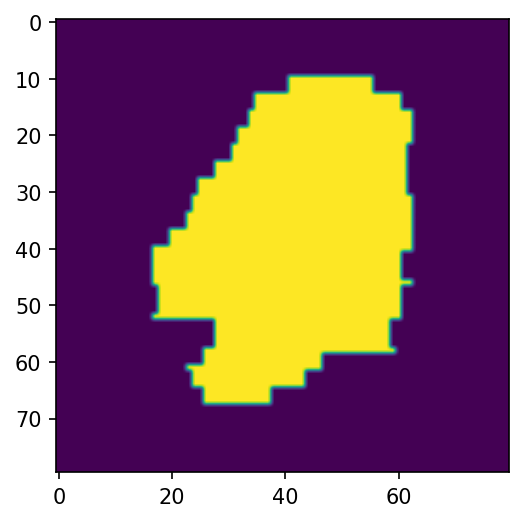

In [43]:
N = 256
grid_spacing = 64

grid = sitk.GridSource(
    outputPixelType=sitk.sitkFloat32,
    size=(N, N, N),
    sigma=(0.5, 0.5, 0.5),
    gridSpacing=(grid_spacing, grid_spacing, grid_spacing),
    gridOffset=(0, 0, 0),
    spacing=(1, 1, 1),
)

array = sitk.GetArrayViewFromImage(img_mhd)
fig, ax = plt.subplots(dpi=150)
ax.imshow(
    array[:,:,40],
    interpolation='hamming',
)

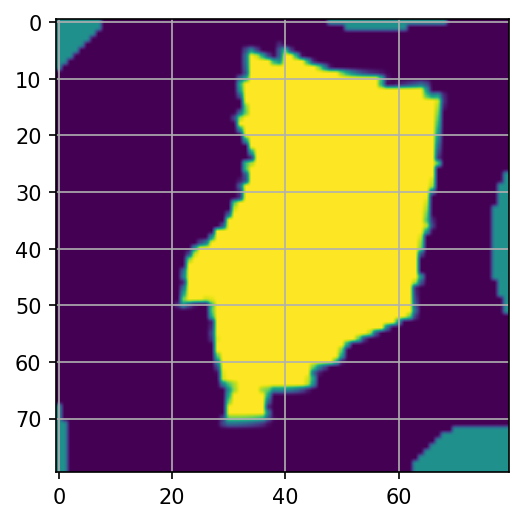

In [222]:
# ctrl_pts = 7, 7, 7
# fix_edges = 3

# ctrl_pts = np.array(ctrl_pts, np.uint32)
# SPLINE_ORDER = 3
# mesh_size = ctrl_pts - SPLINE_ORDER
# transform = sitk.BSplineTransformInitializer(img_mhd, mesh_size.tolist())
# params = transform.GetParameters()

numcontrolpoints, stdDef = 5, 10

transfromDomainMeshSize=[numcontrolpoints]*img_mhd.GetDimension()

transform = sitk.BSplineTransformInitializer(img_mhd,transfromDomainMeshSize)

params = tx.GetParameters()

paramsNp= np.asarray(params,dtype=float)
paramsNp = paramsNp + np.random.randn(paramsNp.shape[0])*stdDef

#     paramsNp[0:int(len(params)/3)]=0 #along z deformation
#     paramsNp[int(len(params)/3):int(len(params)*2/3)]=0 # along y deformation
#     paramsNp[int(len(params)*2/3):]=0 # along x deformation

params=tuple(paramsNp)
transform.SetParameters(params)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(img_mhd)
resampler.SetTransform(transform)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0.5)
resampler.SetOutputPixelType(sitk.sitkFloat32)
resampled = resampler.Execute(img_mhd)

array = sitk.GetArrayViewFromImage(resampled)

fig, ax = plt.subplots(dpi=150)
ax.grid()
ax.imshow(
    array[:,:,40],
    #extent=[
    #    0, resampled.GetSize()[1] * resampled.GetSpacing()[1],
    #    0, resampled.GetSize()[0] * resampled.GetSpacing()[0],
    #],
    interpolation='hamming',
)


displacementField = sitk.TransformToDisplacementField(transform, 
                                  sitk.sitkVectorFloat64,
                                  resampled.GetSize(),
                                  resampled.GetOrigin(),
                                  resampled.GetSpacing(),
                                  resampled.GetDirection())
# print(displacementField)
# sitk.WriteTransform(displacementField, "deformation_field.txt")

In [221]:
elastixImageFilter = sitk.SimpleElastix()
elastixImageFilter.SetFixedImage(resampled)
elastixImageFilter.SetMovingImage(img_mhd)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.Execute()

transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(elastixImageFilter.GetTransformParameterMap())
transformixImageFilter.ComputeDeformationFieldOn()
transformixImageFilter.Execute()
deformationField = transformixImageFilter.GetDeformationField()

parameterMapVector = elastixImageFilter.GetParameterMap()

AttributeError: module 'SimpleITK' has no attribute 'SimpleElastix'